In [1]:
!pip install optuna torch

  Using cached torch-2.6.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.6.0-cp311-cp311-win_amd64.whl (204.2 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

from utils import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

c:\Users\Pablo\anaconda3\envs\proyecto_keepcoding\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Verificar si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [3]:
# Cargar y preprocesar datos
df_estres = pd.read_csv('SWELLdata.csv', decimal=",", delimiter=";")

formateo_fechas(df_estres)
clasificar_momento_dia(df_estres)

,PP,Blok,Condition,timestamp,Valence_rc,Arousal_rc,Dominance,Stress,MentalEffort,MentalDemand,...,ShoulderRight_ElbowRightPlaneZXAxisXstdv,ShoulderRight_ElbowRightPlaneXYAxisYstdv,ShoulderRight_ElbowRightPlaneYZAxisZstdv,ElbowRight_WristRightPlaneZXAxisXstdv,ElbowRight_WristRightPlaneXYAxisYstdv,ElbowRight_WristRightPlaneYZAxisZstdv,WristRight_HandRightPlaneZXAxisXstdv,WristRight_HandRightPlaneXYAxisYstdv,WristRight_HandRightKinectZAxisstdv,momento_dia
0,PP1,1,R,2012-09-18 13:16:00,NaN,NaN,NaN,NaN,NaN,NaN,...,22.946337,5.605230,13.237048,30.932939,102.460262,8.444481,54.436879,75.886750,155.734343,tarde
1,PP1,1,R,2012-09-18 13:17:00,NaN,NaN,NaN,NaN,NaN,NaN,...,7.194860,2.468881,3.886001,2.000359,3.431337,1.160298,4.579341,2.868843,171.486911,tarde
2,PP1,1,R,2012-09-18 13:18:00,NaN,NaN,NaN,NaN,NaN,NaN,...,14.726365,2.953021,9.185623,13.379140,48.162012,30.508877,23.013755,30.629061,149.748809,tarde
3,PP1,1,R,2012-09-18 13:19:00,NaN,NaN,NaN,NaN,NaN,NaN,...,2.542686,1.564318,2.453674,4.796273,8.223865,1.114906,3.854074,4.048611,173.149430,tarde
4,PP1,1,R,2012-09-18 13:20:00,NaN,NaN,NaN,NaN,NaN,NaN,...,9.905241,20.342488,5.552234,7.198096,22.942488,46.386278,17.514534,29.702675,165.368301,tarde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,PP25,3,T,2012-11-07 16:15:00,9.0,8.0,9.0,0.3,2.7,3.6,...,36.355940,5.323538,17.908446,56.076888,124.607529,15.482486,87.838259,158.284130,38.905423,tarde
3135,PP25,3,T,2012-11-07 16:16:00,9.0,8.0,9.0,0.3,2.7,3.6,...,14.714479,1.848907,3.908359,34.878709,159.984897,5.233569,63.512098,164.607803,27.895148,tarde
3136,PP25,3,T,2012-11-07 16:17:00,9.0,8.0,9.0,0.3,2.7,3.6,...,22.742133,3.048023,6.468803,53.988308,169.548392,10.757358,60.488127,142.557094,21.761699,tarde
3137,PP25,3,T,2012-11-07 16:18:00,9.0,8.0,9.0,0.3,2.7,3.6,...,28.595668,27.981837,8.424373,43.183524,55.599939,14.620391,72.590531,163.087296,28.944050,tarde


In [4]:
# Eliminar columnas irrelevantes
columnas_a_eliminar = ['timestamp', 'HR', 'RMSSD', 'SCL', 'Valence_rc', 'Arousal_rc',
                        'Dominance', 'MentalEffort', 'MentalDemand', 'PhysicalDemand',
                        'TemporalDemand', 'Effort', 'Performance_rc', 'Frustration',
                        'NasaTLX', 'Squality', 'Sneutral', 'Shappy', 'Ssad', 'Sangry',
                        'Ssurprised', 'Sscared', 'Sdisgusted', 'Svalence']
df_estres = eliminar_columnas(df_estres, columnas_a_eliminar)

Se eliminaron las columnas: ['timestamp', 'HR', 'RMSSD', 'SCL', 'Valence_rc', 'Arousal_rc', 'Dominance', 'MentalEffort', 'MentalDemand', 'PhysicalDemand', 'TemporalDemand', 'Effort', 'Performance_rc', 'Frustration', 'NasaTLX', 'Squality', 'Sneutral', 'Shappy', 'Ssad', 'Sangry', 'Ssurprised', 'Sscared', 'Sdisgusted', 'Svalence']


In [5]:
# Filtrar condición R y momento_día = noche
df_estres = df_estres[df_estres['Condition'] != 'R']
df_estres = df_estres[df_estres['momento_dia'] != 'noche']

In [6]:
# Reordenar columna 'momento_dia'
cols = list(df_estres.columns)
cols.pop(cols.index('momento_dia'))
cols.insert(3, 'momento_dia')
df_estres = df_estres[cols]

In [7]:
# Dividir datos en Train (60%), Eval (20%) y Test (20%)
X = df_estres.drop('Stress', axis=1)
y = df_estres['Stress']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True)

In [8]:
# Eliminar PP de cada conjunto
for dataset in [X_train, X_eval, X_test]:
    dataset.drop(columns=['PP'], inplace=True)

In [9]:
# Aplicar la misma imputación a cada dataset
stats_X_train = X_train.describe().T[['mean', '50%']].assign(mode=X_train.mode().iloc[0])

def imputar_valores(df, stats):
    for col in df.columns:
        if col in stats.index:
            moda, mediana, media = stats.loc[col, ['mode', '50%', 'mean']]
            df[col] = df[col].fillna(moda if moda != 0 else mediana if mediana != 0 else media)
    return df

X_train = imputar_valores(X_train, stats_X_train)
X_eval = imputar_valores(X_eval, stats_X_train)
X_test = imputar_valores(X_test, stats_X_train)

In [10]:
# Convertir categóricas a tipo category y aplicar One-Hot Encoding
for dataset in [X_train, X_eval, X_test]:
    for col in ['Blok', 'Condition', 'momento_dia']:
        dataset[col] = dataset[col].astype('category')
    dataset = pd.get_dummies(dataset, columns=['Blok', 'Condition', 'momento_dia'])

X_train = pd.get_dummies(X_train, columns=['Blok', 'Condition', 'momento_dia'])
X_eval = pd.get_dummies(X_eval, columns=['Blok', 'Condition', 'momento_dia'])
X_test = pd.get_dummies(X_test, columns=['Blok', 'Condition', 'momento_dia'])

In [11]:
# Eliminar columnas altamente correlacionadas (>0.9)
corr_matrix = X_train.corr().abs()
high_corr_cols = {corr_matrix.columns[i] for i in range(len(corr_matrix.columns))
                  for j in range(i) if corr_matrix.iloc[i, j] > 0.9}

X_train.drop(columns=high_corr_cols, inplace=True)
X_eval.drop(columns=high_corr_cols, inplace=True)
X_test.drop(columns=high_corr_cols, inplace=True)

print(f"Eliminadas {len(high_corr_cols)} columnas altamente correlacionadas: {list(high_corr_cols)}")

Eliminadas 23 columnas altamente correlacionadas: ['SAu25_LipsPart', 'Condition_N', 'ShoulderCenter_ShoulderRightPlaneYZAxisZavg', 'ShoulderCenter_ShoulderLeftShoulderLeft_ElbowLeftavg', 'Spine_ShoulderCenterPlaneYZAxisZavg', 'Spine_ShoulderCenterPlaneYZAxisZstdv', 'ShoulderRight_ElbowRightPlaneXYAxisYavg', 'Spine_ShoulderCenterShoulderCenter_ShoulderLeftavg', 'HipCenter_SpineSpine_ShoulderCenteravg', 'SnChars', 'HipCenter_SpinePlaneXYAxisYavg', 'Spine_ShoulderCenterPlaneXYAxisYstdv', 'HipCenter_SpinePlaneYZAxisZavg', 'ShoulderCenter_ShoulderRightPlaneXYAxisYavg', 'SnSpaces', 'Spine_ShoulderCenterPlaneXYAxisYavg', 'ShoulderCenter_ShoulderRightPlaneXYAxisYstdv', 'Spine_ShoulderCenterShoulderCenter_Headavg', 'ShoulderCenter_ShoulderLeftPlaneXYAxisYavg', 'momento_dia_tarde', 'ShoulderCenter_ShoulderRightPlaneZXAxisXavg', 'ShoulderCenter_ShoulderLeftPlaneXYAxisYstdv', 'ElbowLeft_WristLeftWristLeft_HandLeftavg']


In [14]:
X_train_columns = X_train.columns
X_train_columns

Index(['SyHeadOrientation', 'SxHeadOrientation', 'SzHeadOrientation',
       'SmouthOpen', 'SleftEyeClosed', 'SrightEyeClosed',
       'SleftEyebrowLowered', 'SleftEyebrowRaised', 'SrightEyebrowLowered',
       'SrightEyebrowRaised',
       ...
       'ElbowRight_WristRightPlaneYZAxisZstdv',
       'WristRight_HandRightPlaneZXAxisXstdv',
       'WristRight_HandRightPlaneXYAxisYstdv',
       'WristRight_HandRightKinectZAxisstdv', 'Blok_1', 'Blok_2', 'Blok_3',
       'Condition_I', 'Condition_T', 'momento_dia_mañana'],
      dtype='object', length=129)

In [15]:
# Normalizar datos
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_eval = scaler_X.transform(X_eval)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_eval = scaler_y.transform(y_eval.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

In [16]:
# Convertir a tensores
def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32, device=device), torch.tensor(y, dtype=torch.float32, device=device)

X_train_tensor, y_train_tensor = to_tensor(X_train, y_train)
X_eval_tensor, y_eval_tensor = to_tensor(X_eval, y_eval)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

In [17]:
# Cargar en DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
eval_loader = DataLoader(TensorDataset(X_eval_tensor, y_eval_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)


In [18]:
## Definir modelo LSTM 1
#class StressLSTM(nn.Module):
#    def __init__(self, input_dim, hidden_dim, num_layers):
#        super(StressLSTM, self).__init__()
#        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#        self.fc = nn.Linear(hidden_dim, 1)
#
#    def forward(self, x):
#        lstm_out, _ = self.lstm(x.unsqueeze(1))  # Agregar dimensión temporal
#        return self.fc(lstm_out[:, -1, :])  # Tomar la última salida del LSTM

In [19]:
class StressLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(StressLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))  # (batch, seq_len=1, input_dim)
        lstm_out = self.batch_norm(lstm_out[:, -1, :])  # Última salida del LSTM con batch norm
        return self.fc(lstm_out)  # Pasar por la capa totalmente conectada

In [20]:
## Optuna para optimizar hiperparámetros_1
#def objective(trial):
#    hidden_dim = trial.suggest_int("hidden_dim", 16, 128)
#    num_layers = trial.suggest_int("num_layers", 1, 3)
#    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
#    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
#    criterion_name = trial.suggest_categorical("criterion", ["MSELoss", "L1Loss", "HuberLoss"])
#
#    model = StressLSTM(input_dim=X_train.shape[1], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
#    criterion = getattr(nn, criterion_name)()
#    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
#
#    # Entrenamiento
#    for epoch in range(10):
#        model.train()
#        for X_batch, y_batch in train_loader:
#            optimizer.zero_grad()
#            y_pred = model(X_batch)
#            loss = criterion(y_pred, y_batch)
#            loss.backward()
#            optimizer.step()
#
#    # Evaluación en conjunto de validación
#    model.eval()
#    eval_loss = 0
#    with torch.no_grad():
#        for X_batch, y_batch in eval_loader:
#            y_pred = model(X_batch)
#            eval_loss += criterion(y_pred, y_batch).item()
#
#    return eval_loss

In [21]:
#def objective(trial):
#    hidden_dim = trial.suggest_int("hidden_dim", 16, 128)
#    num_layers = trial.suggest_int("num_layers", 1, 3)
#    dropout = trial.suggest_float("dropout", 0.2, 0.5) if num_layers > 1 else 0.0
#    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
#    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
#    criterion_name = trial.suggest_categorical("criterion", ["MSELoss", "L1Loss", "HuberLoss"])
#
#    # Inicializar modelo
#    model = StressLSTM(input_dim=X_train.shape[1], hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
#    criterion = getattr(nn, criterion_name)()
#    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
#
#    # Entrenamiento
#    for epoch in range(10):
#        model.train()
#        for X_batch, y_batch in train_loader:
#            optimizer.zero_grad()
#            y_pred = model(X_batch)
#            loss = criterion(y_pred, y_batch)
#            loss.backward()
#            optimizer.step()
#
#    # Evaluación en conjunto de validación
#    model.eval()
#    eval_loss = 0
#    with torch.no_grad():
#        for X_batch, y_batch in eval_loader:
#            y_pred = model(X_batch)
#            eval_loss += criterion(y_pred, y_batch).item()
#
#    return eval_loss
#
## Ejecutar Optuna
#study = optuna.create_study(direction="minimize")
#study.optimize(objective, n_trials=50)
#
## Mejor conjunto de hiperparámetros
#best_params = study.best_params
#print("Mejores Hiperparámetros:", best_params)

In [22]:
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5) if num_layers > 1 else 0.0
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    criterion_name = trial.suggest_categorical("criterion", ["MSELoss", "L1Loss", "HuberLoss"])

    model = StressLSTM(input_dim=X_train.shape[1], hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
    criterion = getattr(nn, criterion_name)()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)

    patience = 5
    best_loss = float("inf")
    epochs_no_improve = 0
    best_model = None

    for epoch in range(50):  # Aumentar número de épocas si es necesario
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in eval_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                eval_loss += criterion(y_pred, y_batch).item()
        eval_loss /= len(eval_loader)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Eval Loss: {eval_loss:.4f}")

        if eval_loss < best_loss:
            best_loss = eval_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    model.load_state_dict(best_model)
    return best_loss

In [42]:
# Ejecutar Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Mostrar mejores parámetros encontrados
print("Best trial:", study.best_trial.params)

[I 2025-03-19 17:45:31,095] A new study created in memory with name: no-name-a9be8806-374e-465c-af71-a3edd5953ecd


Epoch 1: Train Loss: 0.3903 | Eval Loss: 0.3602
Epoch 2: Train Loss: 0.2633 | Eval Loss: 0.2150
Epoch 3: Train Loss: 0.1950 | Eval Loss: 0.1364
Epoch 4: Train Loss: 0.1756 | Eval Loss: 0.1204
Epoch 5: Train Loss: 0.1633 | Eval Loss: 0.0966
Epoch 6: Train Loss: 0.1283 | Eval Loss: 0.1050
Epoch 7: Train Loss: 0.1280 | Eval Loss: 0.0896
Epoch 8: Train Loss: 0.1216 | Eval Loss: 0.0905
Epoch 9: Train Loss: 0.1076 | Eval Loss: 0.0859
Epoch 10: Train Loss: 0.1082 | Eval Loss: 0.0748
Epoch 11: Train Loss: 0.0921 | Eval Loss: 0.0734
Epoch 12: Train Loss: 0.0972 | Eval Loss: 0.0747
Epoch 13: Train Loss: 0.0844 | Eval Loss: 0.0671
Epoch 14: Train Loss: 0.0862 | Eval Loss: 0.0620
Epoch 15: Train Loss: 0.0791 | Eval Loss: 0.0631
Epoch 16: Train Loss: 0.0840 | Eval Loss: 0.0719
Epoch 17: Train Loss: 0.0755 | Eval Loss: 0.0570
Epoch 18: Train Loss: 0.0705 | Eval Loss: 0.0602
Epoch 19: Train Loss: 0.0770 | Eval Loss: 0.0619
Epoch 20: Train Loss: 0.0748 | Eval Loss: 0.0554
Epoch 21: Train Loss: 0.0759 

[I 2025-03-19 17:45:38,751] Trial 0 finished with value: 0.047509434906875384 and parameters: {'hidden_dim': 16, 'num_layers': 3, 'dropout': 0.3589018487965726, 'optimizer': 'Adam', 'lr': 0.009025866951602434, 'criterion': 'HuberLoss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 40: Train Loss: 0.0629 | Eval Loss: 0.0576
Early stopping triggered at epoch 40
Epoch 1: Train Loss: 0.8515 | Eval Loss: 0.9547
Epoch 2: Train Loss: 0.5499 | Eval Loss: 0.5028
Epoch 3: Train Loss: 0.4361 | Eval Loss: 0.3617
Epoch 4: Train Loss: 0.3691 | Eval Loss: 0.3234
Epoch 5: Train Loss: 0.3151 | Eval Loss: 0.2922
Epoch 6: Train Loss: 0.2876 | Eval Loss: 0.2588
Epoch 7: Train Loss: 0.2459 | Eval Loss: 0.2350
Epoch 8: Train Loss: 0.2206 | Eval Loss: 0.2240
Epoch 9: Train Loss: 0.2113 | Eval Loss: 0.2128
Epoch 10: Train Loss: 0.1898 | Eval Loss: 0.2113
Epoch 11: Train Loss: 0.1936 | Eval Loss: 0.2124
Epoch 12: Train Loss: 0.1766 | Eval Loss: 0.1989
Epoch 13: Train Loss: 0.1554 | Eval Loss: 0.1839
Epoch 14: Train Loss: 0.1604 | Eval Loss: 0.1835
Epoch 15: Train Loss: 0.1523 | Eval Loss: 0.1706
Epoch 16: Train Loss: 0.1568 | Eval Loss: 0.1878
Epoch 17: Train Loss: 0.1408 | Eval Loss: 0.1664
Epoch 18: Train Loss: 0.1350 | Eval Loss: 0.1631
Epoch 19: Train Loss: 0.1332 | Eval Loss:

[I 2025-03-19 17:45:47,594] Trial 1 finished with value: 0.12851247191429138 and parameters: {'hidden_dim': 124, 'num_layers': 3, 'dropout': 0.29370266126815014, 'optimizer': 'Adam', 'lr': 0.0006813503834572497, 'criterion': 'MSELoss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 41: Train Loss: 0.0865 | Eval Loss: 0.1424
Early stopping triggered at epoch 41
Epoch 1: Train Loss: 1.1080 | Eval Loss: 1.0065
Epoch 2: Train Loss: 0.9506 | Eval Loss: 0.8928
Epoch 3: Train Loss: 0.8373 | Eval Loss: 0.7983
Epoch 4: Train Loss: 0.7971 | Eval Loss: 0.7188
Epoch 5: Train Loss: 0.7129 | Eval Loss: 0.6442
Epoch 6: Train Loss: 0.6534 | Eval Loss: 0.5733
Epoch 7: Train Loss: 0.5604 | Eval Loss: 0.5220
Epoch 8: Train Loss: 0.5419 | Eval Loss: 0.4892
Epoch 9: Train Loss: 0.5083 | Eval Loss: 0.4401
Epoch 10: Train Loss: 0.4600 | Eval Loss: 0.4163
Epoch 11: Train Loss: 0.4251 | Eval Loss: 0.3787
Epoch 12: Train Loss: 0.3985 | Eval Loss: 0.3648
Epoch 13: Train Loss: 0.3793 | Eval Loss: 0.3539
Epoch 14: Train Loss: 0.3621 | Eval Loss: 0.3415
Epoch 15: Train Loss: 0.3554 | Eval Loss: 0.3260
Epoch 16: Train Loss: 0.3287 | Eval Loss: 0.3043
Epoch 17: Train Loss: 0.3167 | Eval Loss: 0.3071
Epoch 18: Train Loss: 0.3155 | Eval Loss: 0.3031
Epoch 19: Train Loss: 0.3089 | Eval Loss:

[I 2025-03-19 17:45:56,022] Trial 2 finished with value: 0.21232914091909633 and parameters: {'hidden_dim': 36, 'num_layers': 3, 'dropout': 0.3220215287505668, 'optimizer': 'Adam', 'lr': 0.0002874314817128679, 'criterion': 'MSELoss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 40: Train Loss: 0.2007 | Eval Loss: 0.2129
Epoch 41: Train Loss: 0.2084 | Eval Loss: 0.2210
Early stopping triggered at epoch 41
Epoch 1: Train Loss: 0.9024 | Eval Loss: 0.8053
Epoch 2: Train Loss: 0.7706 | Eval Loss: 0.7339
Epoch 3: Train Loss: 0.7143 | Eval Loss: 0.6936
Epoch 4: Train Loss: 0.6883 | Eval Loss: 0.6665
Epoch 5: Train Loss: 0.6587 | Eval Loss: 0.6425
Epoch 6: Train Loss: 0.6369 | Eval Loss: 0.6255
Epoch 7: Train Loss: 0.6171 | Eval Loss: 0.6115
Epoch 8: Train Loss: 0.6049 | Eval Loss: 0.6025
Epoch 9: Train Loss: 0.5833 | Eval Loss: 0.5899
Epoch 10: Train Loss: 0.5779 | Eval Loss: 0.5838
Epoch 11: Train Loss: 0.5806 | Eval Loss: 0.5800
Epoch 12: Train Loss: 0.5571 | Eval Loss: 0.5720
Epoch 13: Train Loss: 0.5549 | Eval Loss: 0.5667
Epoch 14: Train Loss: 0.5472 | Eval Loss: 0.5647
Epoch 15: Train Loss: 0.5305 | Eval Loss: 0.5569
Epoch 16: Train Loss: 0.5289 | Eval Loss: 0.5478
Epoch 17: Train Loss: 0.5207 | Eval Loss: 0.5469
Epoch 18: Train Loss: 0.5090 | Eval Loss:

[I 2025-03-19 17:46:02,871] Trial 3 finished with value: 0.43193961241666007 and parameters: {'hidden_dim': 19, 'num_layers': 1, 'optimizer': 'SGD', 'lr': 0.007339169531779238, 'criterion': 'L1Loss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 49: Train Loss: 0.3645 | Eval Loss: 0.4319
Epoch 50: Train Loss: 0.3603 | Eval Loss: 0.4340
Epoch 1: Train Loss: 0.9463 | Eval Loss: 0.8823
Epoch 2: Train Loss: 0.8457 | Eval Loss: 0.8255
Epoch 3: Train Loss: 0.7766 | Eval Loss: 0.7751
Epoch 4: Train Loss: 0.7257 | Eval Loss: 0.7280
Epoch 5: Train Loss: 0.6770 | Eval Loss: 0.6896
Epoch 6: Train Loss: 0.6387 | Eval Loss: 0.6600
Epoch 7: Train Loss: 0.5992 | Eval Loss: 0.6339
Epoch 8: Train Loss: 0.5747 | Eval Loss: 0.6123
Epoch 9: Train Loss: 0.5483 | Eval Loss: 0.5949
Epoch 10: Train Loss: 0.5167 | Eval Loss: 0.5747
Epoch 11: Train Loss: 0.5089 | Eval Loss: 0.5671
Epoch 12: Train Loss: 0.4917 | Eval Loss: 0.5465
Epoch 13: Train Loss: 0.4788 | Eval Loss: 0.5361
Epoch 14: Train Loss: 0.4568 | Eval Loss: 0.5215
Epoch 15: Train Loss: 0.4372 | Eval Loss: 0.5106
Epoch 16: Train Loss: 0.4186 | Eval Loss: 0.4983
Epoch 17: Train Loss: 0.4177 | Eval Loss: 0.4916
Epoch 18: Train Loss: 0.4014 | Eval Loss: 0.4806
Epoch 19: Train Loss: 0.3899 

[I 2025-03-19 17:46:10,968] Trial 4 finished with value: 0.37653837835087495 and parameters: {'hidden_dim': 30, 'num_layers': 1, 'optimizer': 'Adam', 'lr': 0.00014197946057034372, 'criterion': 'L1Loss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 49: Train Loss: 0.2649 | Eval Loss: 0.3794
Epoch 50: Train Loss: 0.2445 | Eval Loss: 0.3816
Epoch 1: Train Loss: 0.6472 | Eval Loss: 0.5462
Epoch 2: Train Loss: 0.4841 | Eval Loss: 0.3923
Epoch 3: Train Loss: 0.3797 | Eval Loss: 0.3814
Epoch 4: Train Loss: 0.3457 | Eval Loss: 0.3385
Epoch 5: Train Loss: 0.3226 | Eval Loss: 0.3190
Epoch 6: Train Loss: 0.2952 | Eval Loss: 0.3196
Epoch 7: Train Loss: 0.2799 | Eval Loss: 0.2999
Epoch 8: Train Loss: 0.2783 | Eval Loss: 0.2700
Epoch 9: Train Loss: 0.2799 | Eval Loss: 0.2479
Epoch 10: Train Loss: 0.2621 | Eval Loss: 0.2496
Epoch 11: Train Loss: 0.2665 | Eval Loss: 0.2469
Epoch 12: Train Loss: 0.2637 | Eval Loss: 0.2747
Epoch 13: Train Loss: 0.2392 | Eval Loss: 0.2724
Epoch 14: Train Loss: 0.2329 | Eval Loss: 0.2354
Epoch 15: Train Loss: 0.2132 | Eval Loss: 0.2602
Epoch 16: Train Loss: 0.2446 | Eval Loss: 0.2269
Epoch 17: Train Loss: 0.2383 | Eval Loss: 0.2157
Epoch 18: Train Loss: 0.2298 | Eval Loss: 0.2093
Epoch 19: Train Loss: 0.2450 

[I 2025-03-19 17:46:14,847] Trial 5 finished with value: 0.2092614892651053 and parameters: {'hidden_dim': 20, 'num_layers': 2, 'dropout': 0.17514058470198948, 'optimizer': 'RMSprop', 'lr': 0.005611529442298361, 'criterion': 'L1Loss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 23: Train Loss: 0.2228 | Eval Loss: 0.2281
Early stopping triggered at epoch 23
Epoch 1: Train Loss: 0.8138 | Eval Loss: 0.5710
Epoch 2: Train Loss: 0.4386 | Eval Loss: 0.4271
Epoch 3: Train Loss: 0.3054 | Eval Loss: 0.3686
Epoch 4: Train Loss: 0.2392 | Eval Loss: 0.3310
Epoch 5: Train Loss: 0.1926 | Eval Loss: 0.2977
Epoch 6: Train Loss: 0.1734 | Eval Loss: 0.2939
Epoch 7: Train Loss: 0.1324 | Eval Loss: 0.2716
Epoch 8: Train Loss: 0.1258 | Eval Loss: 0.2757
Epoch 9: Train Loss: 0.1222 | Eval Loss: 0.2459
Epoch 10: Train Loss: 0.1119 | Eval Loss: 0.2665
Epoch 11: Train Loss: 0.0911 | Eval Loss: 0.2432
Epoch 12: Train Loss: 0.0985 | Eval Loss: 0.2695
Epoch 13: Train Loss: 0.0880 | Eval Loss: 0.2430
Epoch 14: Train Loss: 0.0907 | Eval Loss: 0.2371
Epoch 15: Train Loss: 0.0793 | Eval Loss: 0.2161
Epoch 16: Train Loss: 0.0596 | Eval Loss: 0.2304
Epoch 17: Train Loss: 0.0686 | Eval Loss: 0.2229
Epoch 18: Train Loss: 0.0651 | Eval Loss: 0.2188
Epoch 19: Train Loss: 0.0712 | Eval Loss:

[I 2025-03-19 17:46:18,297] Trial 6 finished with value: 0.2161082848906517 and parameters: {'hidden_dim': 105, 'num_layers': 1, 'optimizer': 'Adam', 'lr': 0.0003947755229344281, 'criterion': 'MSELoss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 20: Train Loss: 0.0637 | Eval Loss: 0.2217
Early stopping triggered at epoch 20
Epoch 1: Train Loss: 0.6258 | Eval Loss: 0.5306
Epoch 2: Train Loss: 0.4285 | Eval Loss: 0.4215
Epoch 3: Train Loss: 0.3667 | Eval Loss: 0.4318
Epoch 4: Train Loss: 0.3362 | Eval Loss: 0.4272
Epoch 5: Train Loss: 0.3046 | Eval Loss: 0.3372
Epoch 6: Train Loss: 0.2825 | Eval Loss: 0.3343
Epoch 7: Train Loss: 0.2706 | Eval Loss: 0.3159
Epoch 8: Train Loss: 0.2591 | Eval Loss: 0.3412
Epoch 9: Train Loss: 0.2354 | Eval Loss: 0.3015
Epoch 10: Train Loss: 0.2515 | Eval Loss: 0.3129
Epoch 11: Train Loss: 0.2444 | Eval Loss: 0.2965
Epoch 12: Train Loss: 0.2440 | Eval Loss: 0.3295
Epoch 13: Train Loss: 0.2143 | Eval Loss: 0.3125
Epoch 14: Train Loss: 0.2282 | Eval Loss: 0.2824
Epoch 15: Train Loss: 0.2191 | Eval Loss: 0.2969
Epoch 16: Train Loss: 0.2137 | Eval Loss: 0.2814
Epoch 17: Train Loss: 0.2139 | Eval Loss: 0.2817
Epoch 18: Train Loss: 0.1863 | Eval Loss: 0.2905
Epoch 19: Train Loss: 0.2004 | Eval Loss:

[I 2025-03-19 17:46:22,088] Trial 7 finished with value: 0.26716269026784334 and parameters: {'hidden_dim': 109, 'num_layers': 1, 'optimizer': 'RMSprop', 'lr': 0.0008263116519749416, 'criterion': 'L1Loss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 25: Train Loss: 0.2027 | Eval Loss: 0.2998
Early stopping triggered at epoch 25
Epoch 1: Train Loss: 1.0779 | Eval Loss: 1.0154
Epoch 2: Train Loss: 0.9900 | Eval Loss: 0.9510
Epoch 3: Train Loss: 0.9364 | Eval Loss: 0.8969
Epoch 4: Train Loss: 0.9352 | Eval Loss: 0.8789
Epoch 5: Train Loss: 0.8996 | Eval Loss: 0.8346
Epoch 6: Train Loss: 0.8728 | Eval Loss: 0.7916
Epoch 7: Train Loss: 0.8048 | Eval Loss: 0.7269
Epoch 8: Train Loss: 0.7675 | Eval Loss: 0.7093
Epoch 9: Train Loss: 0.7540 | Eval Loss: 0.6688
Epoch 10: Train Loss: 0.7163 | Eval Loss: 0.6440
Epoch 11: Train Loss: 0.7046 | Eval Loss: 0.6265
Epoch 12: Train Loss: 0.6886 | Eval Loss: 0.6101
Epoch 13: Train Loss: 0.6438 | Eval Loss: 0.5935
Epoch 14: Train Loss: 0.6033 | Eval Loss: 0.5562
Epoch 15: Train Loss: 0.5859 | Eval Loss: 0.5436
Epoch 16: Train Loss: 0.5896 | Eval Loss: 0.5222
Epoch 17: Train Loss: 0.5573 | Eval Loss: 0.5106
Epoch 18: Train Loss: 0.5652 | Eval Loss: 0.5076
Epoch 19: Train Loss: 0.5566 | Eval Loss:

[I 2025-03-19 17:46:31,247] Trial 8 finished with value: 0.31665456645628987 and parameters: {'hidden_dim': 39, 'num_layers': 3, 'dropout': 0.3378639593363911, 'optimizer': 'SGD', 'lr': 0.006426180313522199, 'criterion': 'MSELoss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 50: Train Loss: 0.3306 | Eval Loss: 0.3167
Epoch 1: Train Loss: 0.3644 | Eval Loss: 0.3586
Epoch 2: Train Loss: 0.2565 | Eval Loss: 0.2172
Epoch 3: Train Loss: 0.2072 | Eval Loss: 0.1767
Epoch 4: Train Loss: 0.1662 | Eval Loss: 0.1442
Epoch 5: Train Loss: 0.1381 | Eval Loss: 0.1403
Epoch 6: Train Loss: 0.1297 | Eval Loss: 0.1292
Epoch 7: Train Loss: 0.1048 | Eval Loss: 0.1225
Epoch 8: Train Loss: 0.0973 | Eval Loss: 0.1215
Epoch 9: Train Loss: 0.0849 | Eval Loss: 0.1101
Epoch 10: Train Loss: 0.0815 | Eval Loss: 0.1112
Epoch 11: Train Loss: 0.0709 | Eval Loss: 0.1078
Epoch 12: Train Loss: 0.0770 | Eval Loss: 0.1005
Epoch 13: Train Loss: 0.0755 | Eval Loss: 0.1068
Epoch 14: Train Loss: 0.0717 | Eval Loss: 0.0965
Epoch 15: Train Loss: 0.0668 | Eval Loss: 0.0942
Epoch 16: Train Loss: 0.0638 | Eval Loss: 0.1000
Epoch 17: Train Loss: 0.0622 | Eval Loss: 0.0944
Epoch 18: Train Loss: 0.0571 | Eval Loss: 0.0949
Epoch 19: Train Loss: 0.0608 | Eval Loss: 0.0907
Epoch 20: Train Loss: 0.0599 

[I 2025-03-19 17:46:35,324] Trial 9 finished with value: 0.08920150052975206 and parameters: {'hidden_dim': 35, 'num_layers': 2, 'dropout': 0.14635059045281854, 'optimizer': 'Adam', 'lr': 0.0007234563720977897, 'criterion': 'HuberLoss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 24: Train Loss: 0.0511 | Eval Loss: 0.0912
Epoch 25: Train Loss: 0.0551 | Eval Loss: 0.0901
Early stopping triggered at epoch 25
Epoch 1: Train Loss: 0.4656 | Eval Loss: 0.4278
Epoch 2: Train Loss: 0.4474 | Eval Loss: 0.4184
Epoch 3: Train Loss: 0.4260 | Eval Loss: 0.4127
Epoch 4: Train Loss: 0.4321 | Eval Loss: 0.4085
Epoch 5: Train Loss: 0.4189 | Eval Loss: 0.4059
Epoch 6: Train Loss: 0.4162 | Eval Loss: 0.4026
Epoch 7: Train Loss: 0.4077 | Eval Loss: 0.4010
Epoch 8: Train Loss: 0.4089 | Eval Loss: 0.3979
Epoch 9: Train Loss: 0.4014 | Eval Loss: 0.3962
Epoch 10: Train Loss: 0.4018 | Eval Loss: 0.3930
Epoch 11: Train Loss: 0.4012 | Eval Loss: 0.3911
Epoch 12: Train Loss: 0.3942 | Eval Loss: 0.3881
Epoch 13: Train Loss: 0.3961 | Eval Loss: 0.3855
Epoch 14: Train Loss: 0.3918 | Eval Loss: 0.3820
Epoch 15: Train Loss: 0.3877 | Eval Loss: 0.3805
Epoch 16: Train Loss: 0.3930 | Eval Loss: 0.3776
Epoch 17: Train Loss: 0.3893 | Eval Loss: 0.3755
Epoch 18: Train Loss: 0.3867 | Eval Loss:

[I 2025-03-19 17:46:44,418] Trial 10 finished with value: 0.3011292438296711 and parameters: {'hidden_dim': 67, 'num_layers': 3, 'dropout': 0.4993055791257562, 'optimizer': 'SGD', 'lr': 0.0024985459571473276, 'criterion': 'HuberLoss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 50: Train Loss: 0.3292 | Eval Loss: 0.3021
Epoch 1: Train Loss: 0.3024 | Eval Loss: 0.2851
Epoch 2: Train Loss: 0.1417 | Eval Loss: 0.1315
Epoch 3: Train Loss: 0.0986 | Eval Loss: 0.1065
Epoch 4: Train Loss: 0.0887 | Eval Loss: 0.0926
Epoch 5: Train Loss: 0.0680 | Eval Loss: 0.0818
Epoch 6: Train Loss: 0.0620 | Eval Loss: 0.0930
Epoch 7: Train Loss: 0.0520 | Eval Loss: 0.0777
Epoch 8: Train Loss: 0.0483 | Eval Loss: 0.0727
Epoch 9: Train Loss: 0.0454 | Eval Loss: 0.0725
Epoch 10: Train Loss: 0.0481 | Eval Loss: 0.0761
Epoch 11: Train Loss: 0.0443 | Eval Loss: 0.0689
Epoch 12: Train Loss: 0.0417 | Eval Loss: 0.0766
Epoch 13: Train Loss: 0.0419 | Eval Loss: 0.0692
Epoch 14: Train Loss: 0.0481 | Eval Loss: 0.0741
Epoch 15: Train Loss: 0.0428 | Eval Loss: 0.0716
Epoch 16: Train Loss: 0.0386 | Eval Loss: 0.0649
Epoch 17: Train Loss: 0.0424 | Eval Loss: 0.0643
Epoch 18: Train Loss: 0.0337 | Eval Loss: 0.0628
Epoch 19: Train Loss: 0.0354 | Eval Loss: 0.0622
Epoch 20: Train Loss: 0.0349 

[I 2025-03-19 17:46:52,638] Trial 11 finished with value: 0.049630816039793635 and parameters: {'hidden_dim': 58, 'num_layers': 2, 'dropout': 0.11848625890081192, 'optimizer': 'Adam', 'lr': 0.0024231759422705186, 'criterion': 'HuberLoss'}. Best is trial 0 with value: 0.047509434906875384.


Epoch 50: Train Loss: 0.0210 | Eval Loss: 0.0511
Epoch 1: Train Loss: 0.3511 | Eval Loss: 0.3060
Epoch 2: Train Loss: 0.2141 | Eval Loss: 0.1472
Epoch 3: Train Loss: 0.1590 | Eval Loss: 0.1395
Epoch 4: Train Loss: 0.1448 | Eval Loss: 0.1249
Epoch 5: Train Loss: 0.1154 | Eval Loss: 0.1101
Epoch 6: Train Loss: 0.1058 | Eval Loss: 0.0906
Epoch 7: Train Loss: 0.0930 | Eval Loss: 0.0854
Epoch 8: Train Loss: 0.0901 | Eval Loss: 0.0823
Epoch 9: Train Loss: 0.0814 | Eval Loss: 0.0797
Epoch 10: Train Loss: 0.0783 | Eval Loss: 0.0780
Epoch 11: Train Loss: 0.0755 | Eval Loss: 0.0785
Epoch 12: Train Loss: 0.0690 | Eval Loss: 0.0724
Epoch 13: Train Loss: 0.0703 | Eval Loss: 0.0625
Epoch 14: Train Loss: 0.0688 | Eval Loss: 0.0722
Epoch 15: Train Loss: 0.0663 | Eval Loss: 0.0699
Epoch 16: Train Loss: 0.0616 | Eval Loss: 0.0659
Epoch 17: Train Loss: 0.0640 | Eval Loss: 0.0660
Epoch 18: Train Loss: 0.0548 | Eval Loss: 0.0617
Epoch 19: Train Loss: 0.0519 | Eval Loss: 0.0577
Epoch 20: Train Loss: 0.0548 

[I 2025-03-19 17:47:01,409] Trial 12 finished with value: 0.04215869417085367 and parameters: {'hidden_dim': 66, 'num_layers': 2, 'dropout': 0.43569622483440046, 'optimizer': 'Adam', 'lr': 0.002335789745233905, 'criterion': 'HuberLoss'}. Best is trial 12 with value: 0.04215869417085367.


Epoch 50: Train Loss: 0.0279 | Eval Loss: 0.0432
Epoch 1: Train Loss: 0.3535 | Eval Loss: 0.3037
Epoch 2: Train Loss: 0.2208 | Eval Loss: 0.1494
Epoch 3: Train Loss: 0.1545 | Eval Loss: 0.1305
Epoch 4: Train Loss: 0.1282 | Eval Loss: 0.1095
Epoch 5: Train Loss: 0.1097 | Eval Loss: 0.0994
Epoch 6: Train Loss: 0.1006 | Eval Loss: 0.0939
Epoch 7: Train Loss: 0.0936 | Eval Loss: 0.0875
Epoch 8: Train Loss: 0.0907 | Eval Loss: 0.0812
Epoch 9: Train Loss: 0.0822 | Eval Loss: 0.0738
Epoch 10: Train Loss: 0.0782 | Eval Loss: 0.0673
Epoch 11: Train Loss: 0.0723 | Eval Loss: 0.0735
Epoch 12: Train Loss: 0.0661 | Eval Loss: 0.0682
Epoch 13: Train Loss: 0.0552 | Eval Loss: 0.0624
Epoch 14: Train Loss: 0.0690 | Eval Loss: 0.0599
Epoch 15: Train Loss: 0.0618 | Eval Loss: 0.0675
Epoch 16: Train Loss: 0.0619 | Eval Loss: 0.0661
Epoch 17: Train Loss: 0.0511 | Eval Loss: 0.0590
Epoch 18: Train Loss: 0.0513 | Eval Loss: 0.0609
Epoch 19: Train Loss: 0.0542 | Eval Loss: 0.0652
Epoch 20: Train Loss: 0.0512 

[I 2025-03-19 17:47:10,293] Trial 13 finished with value: 0.033619585501797056 and parameters: {'hidden_dim': 88, 'num_layers': 2, 'dropout': 0.4550597814102049, 'optimizer': 'Adam', 'lr': 0.0024194873065368078, 'criterion': 'HuberLoss'}. Best is trial 13 with value: 0.033619585501797056.


Epoch 50: Train Loss: 0.0243 | Eval Loss: 0.0350
Epoch 1: Train Loss: 0.3604 | Eval Loss: 0.3091
Epoch 2: Train Loss: 0.2327 | Eval Loss: 0.1728
Epoch 3: Train Loss: 0.1810 | Eval Loss: 0.1397
Epoch 4: Train Loss: 0.1450 | Eval Loss: 0.1223
Epoch 5: Train Loss: 0.1305 | Eval Loss: 0.1118
Epoch 6: Train Loss: 0.1302 | Eval Loss: 0.1098
Epoch 7: Train Loss: 0.1068 | Eval Loss: 0.0986
Epoch 8: Train Loss: 0.0913 | Eval Loss: 0.0871
Epoch 9: Train Loss: 0.0858 | Eval Loss: 0.0816
Epoch 10: Train Loss: 0.0820 | Eval Loss: 0.0770
Epoch 11: Train Loss: 0.0777 | Eval Loss: 0.0797
Epoch 12: Train Loss: 0.0730 | Eval Loss: 0.0765
Epoch 13: Train Loss: 0.0760 | Eval Loss: 0.0705
Epoch 14: Train Loss: 0.0633 | Eval Loss: 0.0692
Epoch 15: Train Loss: 0.0606 | Eval Loss: 0.0640
Epoch 16: Train Loss: 0.0631 | Eval Loss: 0.0630
Epoch 17: Train Loss: 0.0659 | Eval Loss: 0.0630
Epoch 18: Train Loss: 0.0564 | Eval Loss: 0.0649
Epoch 19: Train Loss: 0.0601 | Eval Loss: 0.0602
Epoch 20: Train Loss: 0.0562 

[I 2025-03-19 17:47:19,296] Trial 14 finished with value: 0.03452780793475754 and parameters: {'hidden_dim': 88, 'num_layers': 2, 'dropout': 0.48513496863559186, 'optimizer': 'Adam', 'lr': 0.0021654398365495704, 'criterion': 'HuberLoss'}. Best is trial 13 with value: 0.033619585501797056.


Epoch 50: Train Loss: 0.0311 | Eval Loss: 0.0362
Epoch 1: Train Loss: 0.3511 | Eval Loss: 0.2512
Epoch 2: Train Loss: 0.1989 | Eval Loss: 0.1533
Epoch 3: Train Loss: 0.1603 | Eval Loss: 0.1323
Epoch 4: Train Loss: 0.1447 | Eval Loss: 0.1228
Epoch 5: Train Loss: 0.1299 | Eval Loss: 0.0992
Epoch 6: Train Loss: 0.1116 | Eval Loss: 0.0927
Epoch 7: Train Loss: 0.1047 | Eval Loss: 0.1007
Epoch 8: Train Loss: 0.0908 | Eval Loss: 0.0812
Epoch 9: Train Loss: 0.0911 | Eval Loss: 0.0885
Epoch 10: Train Loss: 0.0822 | Eval Loss: 0.0699
Epoch 11: Train Loss: 0.0770 | Eval Loss: 0.0807
Epoch 12: Train Loss: 0.0813 | Eval Loss: 0.0661
Epoch 13: Train Loss: 0.0689 | Eval Loss: 0.0711
Epoch 14: Train Loss: 0.0728 | Eval Loss: 0.0651
Epoch 15: Train Loss: 0.0692 | Eval Loss: 0.0723
Epoch 16: Train Loss: 0.0672 | Eval Loss: 0.0673
Epoch 17: Train Loss: 0.0616 | Eval Loss: 0.0669


[I 2025-03-19 17:47:22,393] Trial 15 finished with value: 0.06505721566431663 and parameters: {'hidden_dim': 83, 'num_layers': 2, 'dropout': 0.49827469582706263, 'optimizer': 'RMSprop', 'lr': 0.001498391521630183, 'criterion': 'HuberLoss'}. Best is trial 13 with value: 0.033619585501797056.


Epoch 18: Train Loss: 0.0561 | Eval Loss: 0.0726
Epoch 19: Train Loss: 0.0549 | Eval Loss: 0.0651
Early stopping triggered at epoch 19
Epoch 1: Train Loss: 0.3412 | Eval Loss: 0.2602
Epoch 2: Train Loss: 0.1856 | Eval Loss: 0.1485
Epoch 3: Train Loss: 0.1491 | Eval Loss: 0.1144
Epoch 4: Train Loss: 0.1208 | Eval Loss: 0.0999
Epoch 5: Train Loss: 0.0990 | Eval Loss: 0.0882
Epoch 6: Train Loss: 0.0886 | Eval Loss: 0.0780
Epoch 7: Train Loss: 0.0782 | Eval Loss: 0.0815
Epoch 8: Train Loss: 0.0728 | Eval Loss: 0.0778
Epoch 9: Train Loss: 0.0689 | Eval Loss: 0.0711
Epoch 10: Train Loss: 0.0652 | Eval Loss: 0.0661
Epoch 11: Train Loss: 0.0580 | Eval Loss: 0.0694
Epoch 12: Train Loss: 0.0633 | Eval Loss: 0.0701
Epoch 13: Train Loss: 0.0548 | Eval Loss: 0.0611
Epoch 14: Train Loss: 0.0503 | Eval Loss: 0.0638
Epoch 15: Train Loss: 0.0548 | Eval Loss: 0.0597
Epoch 16: Train Loss: 0.0489 | Eval Loss: 0.0619
Epoch 17: Train Loss: 0.0428 | Eval Loss: 0.0526
Epoch 18: Train Loss: 0.0486 | Eval Loss:

[I 2025-03-19 17:47:31,519] Trial 16 finished with value: 0.036222255953094536 and parameters: {'hidden_dim': 87, 'num_layers': 2, 'dropout': 0.41921394035836795, 'optimizer': 'Adam', 'lr': 0.003152305311323993, 'criterion': 'HuberLoss'}. Best is trial 13 with value: 0.033619585501797056.


Epoch 50: Train Loss: 0.0235 | Eval Loss: 0.0369
Epoch 1: Train Loss: 0.3377 | Eval Loss: 0.3175
Epoch 2: Train Loss: 0.2256 | Eval Loss: 0.1780
Epoch 3: Train Loss: 0.1912 | Eval Loss: 0.1489
Epoch 4: Train Loss: 0.1518 | Eval Loss: 0.1325
Epoch 5: Train Loss: 0.1294 | Eval Loss: 0.1155
Epoch 6: Train Loss: 0.1113 | Eval Loss: 0.1161
Epoch 7: Train Loss: 0.1070 | Eval Loss: 0.0937
Epoch 8: Train Loss: 0.0910 | Eval Loss: 0.0921
Epoch 9: Train Loss: 0.0893 | Eval Loss: 0.0890
Epoch 10: Train Loss: 0.0806 | Eval Loss: 0.0838
Epoch 11: Train Loss: 0.0837 | Eval Loss: 0.0900
Epoch 12: Train Loss: 0.0762 | Eval Loss: 0.0739
Epoch 13: Train Loss: 0.0772 | Eval Loss: 0.0736
Epoch 14: Train Loss: 0.0633 | Eval Loss: 0.0766
Epoch 15: Train Loss: 0.0703 | Eval Loss: 0.0762
Epoch 16: Train Loss: 0.0645 | Eval Loss: 0.0719
Epoch 17: Train Loss: 0.0577 | Eval Loss: 0.0695
Epoch 18: Train Loss: 0.0608 | Eval Loss: 0.0663
Epoch 19: Train Loss: 0.0660 | Eval Loss: 0.0644
Epoch 20: Train Loss: 0.0533 

[I 2025-03-19 17:47:38,190] Trial 17 finished with value: 0.052113702739862836 and parameters: {'hidden_dim': 92, 'num_layers': 2, 'dropout': 0.4197905250616065, 'optimizer': 'Adam', 'lr': 0.0013559498770464686, 'criterion': 'HuberLoss'}. Best is trial 13 with value: 0.033619585501797056.


Epoch 38: Train Loss: 0.0406 | Eval Loss: 0.0541
Epoch 39: Train Loss: 0.0390 | Eval Loss: 0.0525
Early stopping triggered at epoch 39
Epoch 1: Train Loss: 0.5143 | Eval Loss: 0.4507
Epoch 2: Train Loss: 0.4398 | Eval Loss: 0.4103
Epoch 3: Train Loss: 0.3959 | Eval Loss: 0.3800
Epoch 4: Train Loss: 0.3728 | Eval Loss: 0.3623
Epoch 5: Train Loss: 0.3544 | Eval Loss: 0.3467
Epoch 6: Train Loss: 0.3383 | Eval Loss: 0.3357
Epoch 7: Train Loss: 0.3310 | Eval Loss: 0.3286
Epoch 8: Train Loss: 0.3184 | Eval Loss: 0.3204
Epoch 9: Train Loss: 0.3119 | Eval Loss: 0.3139
Epoch 10: Train Loss: 0.3049 | Eval Loss: 0.3050
Epoch 11: Train Loss: 0.2965 | Eval Loss: 0.3011
Epoch 12: Train Loss: 0.2913 | Eval Loss: 0.2961
Epoch 13: Train Loss: 0.2842 | Eval Loss: 0.2920
Epoch 14: Train Loss: 0.2769 | Eval Loss: 0.2857
Epoch 15: Train Loss: 0.2711 | Eval Loss: 0.2796
Epoch 16: Train Loss: 0.2613 | Eval Loss: 0.2775
Epoch 17: Train Loss: 0.2572 | Eval Loss: 0.2716
Epoch 18: Train Loss: 0.2561 | Eval Loss:

[I 2025-03-19 17:47:45,578] Trial 18 finished with value: 0.17834423701552785 and parameters: {'hidden_dim': 51, 'num_layers': 1, 'optimizer': 'SGD', 'lr': 0.004218959663005482, 'criterion': 'HuberLoss'}. Best is trial 13 with value: 0.033619585501797056.


Epoch 49: Train Loss: 0.1264 | Eval Loss: 0.1806
Epoch 50: Train Loss: 0.1237 | Eval Loss: 0.1783
Epoch 1: Train Loss: 0.3188 | Eval Loss: 0.2934
Epoch 2: Train Loss: 0.1491 | Eval Loss: 0.1424
Epoch 3: Train Loss: 0.1160 | Eval Loss: 0.1141
Epoch 4: Train Loss: 0.0943 | Eval Loss: 0.1164
Epoch 5: Train Loss: 0.0906 | Eval Loss: 0.0828
Epoch 6: Train Loss: 0.0761 | Eval Loss: 0.0823
Epoch 7: Train Loss: 0.0728 | Eval Loss: 0.0873
Epoch 8: Train Loss: 0.0653 | Eval Loss: 0.0896
Epoch 9: Train Loss: 0.0622 | Eval Loss: 0.0713
Epoch 10: Train Loss: 0.0643 | Eval Loss: 0.0916
Epoch 11: Train Loss: 0.0575 | Eval Loss: 0.0874
Epoch 12: Train Loss: 0.0531 | Eval Loss: 0.0781


[I 2025-03-19 17:47:47,843] Trial 19 finished with value: 0.07126585043528501 and parameters: {'hidden_dim': 78, 'num_layers': 2, 'dropout': 0.25480650476838584, 'optimizer': 'RMSprop', 'lr': 0.0014187289363160412, 'criterion': 'HuberLoss'}. Best is trial 13 with value: 0.033619585501797056.


Epoch 13: Train Loss: 0.0514 | Eval Loss: 0.0761
Epoch 14: Train Loss: 0.0511 | Eval Loss: 0.0776
Early stopping triggered at epoch 14
Best trial: {'hidden_dim': 88, 'num_layers': 2, 'dropout': 0.4550597814102049, 'optimizer': 'Adam', 'lr': 0.0024194873065368078, 'criterion': 'HuberLoss'}


In [43]:
# Entrenar el mejor modelo
best_params = study.best_trial.params
model = StressLSTM(
    input_dim=X_train.shape[1],
    hidden_dim=best_params["hidden_dim"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"]  # Agregar dropout
).to(device)
criterion = getattr(nn, best_params["criterion"])()
optimizer = getattr(optim, best_params["optimizer"])(model.parameters(), lr=best_params["lr"])

--Codigo Pablo, cargo mejores parámetros para no volver a correr optuna

In [23]:
# Entrenar el mejor modelo
# Cargo los mejores parámetros encontrados manualmente
best_params = {'hidden_dim': 88, 'num_layers': 2, 'dropout': 0.4550597814102049, 'optimizer': 'Adam', 'lr': 0.0024194873065368078, 'criterion': 'HuberLoss'}  # Mejores hiperparámetros (excel)
#best_params = study.best_trial.params
model = StressLSTM(
    input_dim=X_train.shape[1],
    hidden_dim=best_params["hidden_dim"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"]  # Agregar dropout
).to(device)
criterion = getattr(nn, best_params["criterion"])()
optimizer = getattr(optim, best_params["optimizer"])(model.parameters(), lr=best_params["lr"])

In [24]:
# Entrenar modelo con los mejores parámetros
epochs = 10
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

In [25]:
# Evaluación en test set
model.eval()
test_loss = 0
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_hat = model(X_batch)
        test_loss += criterion(y_hat, y_batch).item()

        # Guardar valores reales y predichos para métricas
        y_true.extend(y_batch.cpu().numpy().flatten())
        y_pred.extend(y_hat.cpu().numpy().flatten())

# Convertir listas a arrays de NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Imprimir métricas
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Final Test Loss: 1.3872
Mean Absolute Error (MAE): 0.2957
Mean Squared Error (MSE): 0.1714
Root Mean Squared Error (RMSE): 0.4140
R² Score: 0.8189


In [26]:
def evaluate_model(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_hat = model(X_batch)
            total_loss += criterion(y_hat, y_batch).item()

            y_true.extend(y_batch.cpu().numpy().flatten())
            y_pred.extend(y_hat.cpu().numpy().flatten())

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return total_loss, mae, mse, rmse, r2

# Evaluación en train, eval y test
train_loss, train_mae, train_mse, train_rmse, train_r2 = evaluate_model(model, criterion, train_loader, device)
eval_loss, eval_mae, eval_mse, eval_rmse, eval_r2 = evaluate_model(model, criterion, eval_loader, device)
test_loss, test_mae, test_mse, test_rmse, test_r2 = evaluate_model(model, criterion, test_loader, device)

print(f"Train Loss: {train_loss:.4f} | Eval Loss: {eval_loss:.4f} | Test Loss: {test_loss:.4f}")
print(f"Train RMSE: {train_rmse:.4f} | Eval RMSE: {eval_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}   | Eval R²: {eval_r2:.4f}   | Test R²: {test_r2:.4f}")

Train Loss: 1.5249 | Eval Loss: 1.3554 | Test Loss: 1.3872
Train RMSE: 0.2447 | Eval RMSE: 0.4072 | Test RMSE: 0.4140
Train R²: 0.9401   | Eval R²: 0.8534   | Test R²: 0.8189


Over fitting Controlado!

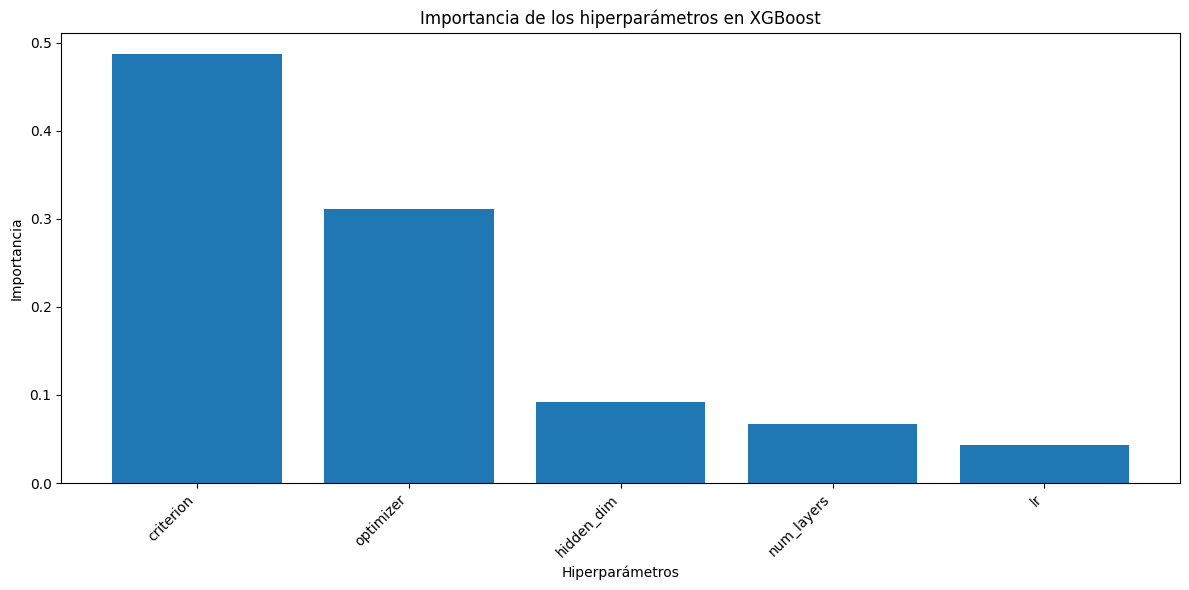

In [48]:
importances = optuna.importance.get_param_importances(study)

plt.figure(figsize=(12, 6))
plt.bar(importances.keys(), importances.values())
plt.xlabel("Hiperparámetros")
plt.ylabel("Importancia")
plt.title("Importancia de los hiperparámetros en LSTM")
plt.xticks(rotation=45, ha="right")  # Rotar etiquetas del eje x para mejor legibilidad
plt.tight_layout()
plt.show()

Guardamos mejores parámetros y métricas

In [27]:
import json
import torch

# 1. Crear un diccionario con las métricas
metrics = {
    "Train": {
        "MSE": train_mse,
        "RMSE": train_rmse,
        "R^2": train_r2,
        "MAE": train_mae,
        "Loss": train_loss
    },
    "Val": {
        "MSE": eval_mse,
        "RMSE": eval_rmse,
        "R^2": eval_r2,
        "MAE": eval_mae,
        "Loss": eval_loss
    },
    "Test": {
        "MSE": test_mse,
        "RMSE": test_rmse,
        "R^2": test_r2,
        "MAE": test_mae,
        "Loss": test_loss
    }
}

# 2. Crear un diccionario con los mejores hiperparámetros
results = {
    "metrics": metrics,
    "best_params": best_params
}

# 3. Guardar todo en un archivo JSON
json_path = "metricas_y_best_params_LSTM.json"
with open(json_path, "w") as f:
    json.dump(results, f, indent=4)

# 4. Guardar el modelo en un archivo .pkl
torch.save(model, "modelo_LSTM.pkl")

# 5. Guardar columnas de X_train
with open('LSTM_X_train_columns.txt', 'w') as f:
    for col in X_train_columns:
        f.write(f"{col}\n")

print(f"Modelo guardado en 'modelo_LSTM.pkl'")
print(f"Métricas y mejores hiperparámetros guardados en '{json_path}'")


Modelo guardado en 'modelo_LSTM.pkl'
Métricas y mejores hiperparámetros guardados en 'metricas_y_best_params_LSTM.json'


--Código Fer

In [59]:
y_true_denormalized = scaler_y.inverse_transform(y_true.reshape(-1, 1))
y_pred_denormalized = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

results_df = pd.DataFrame({'y_true': y_true_denormalized.flatten(), 'y_pred': y_pred_denormalized.flatten()}) # Use denormalized values

display(results_df)

,y_true,y_pred
0,1.3,1.877265
1,4.1,2.864897
2,6.0,5.569900
3,5.9,5.844567
4,4.1,3.250195
...,...,...
533,1.4,1.678861
534,5.0,4.418911
535,6.1,5.996844
536,2.0,1.484212


In [55]:
y_pred.shape

(538,)

In [56]:
y_true.shape

(538,)